# Constant False Alarm Rate (CFAR)
Testing a new (faster) implementation.

<b>Note:</b> This uses a sinc signal as the input which is not very realistic. 
I just used it because it has a main peak which would be considered the signal. 
Will use better data later.

In [150]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sys
sys.path.insert(0, "../../chill/ADI_Radar_DSP/")
from target_detection import cfar as cfar_old

In [152]:
PLOTLY_LAYOUT = {
        "font": {
        "family": "JetBrains Mono",
        "size": 18,
        "color": "white",
        },
        'annotationdefaults': {'arrowcolor': '#f2f5fa', 'arrowhead': 0, 'arrowwidth': 1},
                'autotypenumbers': 'strict',
                'coloraxis': {'colorbar': {'outlinewidth': 0, 'ticks': ''}},
                'colorscale': {'diverging': [[0, '#8e0152'], [0.1, '#c51b7d'], [0.2,
                                        '#de77ae'], [0.3, '#f1b6da'], [0.4, '#fde0ef'],
                                        [0.5, '#f7f7f7'], [0.6, '#e6f5d0'], [0.7,
                                        '#b8e186'], [0.8, '#7fbc41'], [0.9, '#4d9221'],
                                        [1, '#276419']],
                        'sequential': [[0.0, '#0d0887'], [0.1111111111111111,
                                        '#46039f'], [0.2222222222222222, '#7201a8'],
                                        [0.3333333333333333, '#9c179e'],
                                        [0.4444444444444444, '#bd3786'],
                                        [0.5555555555555556, '#d8576b'],
                                        [0.6666666666666666, '#ed7953'],
                                        [0.7777777777777778, '#fb9f3a'],
                                        [0.8888888888888888, '#fdca26'], [1.0,
                                        '#f0f921']],
                        'sequentialminus': [[0.0, '#0d0887'], [0.1111111111111111,
                                                '#46039f'], [0.2222222222222222, '#7201a8'],
                                                [0.3333333333333333, '#9c179e'],
                                                [0.4444444444444444, '#bd3786'],
                                                [0.5555555555555556, '#d8576b'],
                                                [0.6666666666666666, '#ed7953'],
                                                [0.7777777777777778, '#fb9f3a'],
                                                [0.8888888888888888, '#fdca26'], [1.0,
                                                '#f0f921']]},
                # 'colorway': [#636efa, #EF553B, #00cc96, #ab63fa, #FFA15A, #19d3f3, #FF6692,
                #             #B6E880, #FF97FF, #FECB52],
                # 'font': {'color': '#f2f5fa'},
                'geo': {'bgcolor': 'rgb(17,17,17)',
                        'lakecolor': 'rgb(17,17,17)',
                        'landcolor': 'rgb(17,17,17)',
                        'showlakes': True,
                        'showland': True,
                        'subunitcolor': '#506784'},
                'hoverlabel': {'align': 'left'},
                'hovermode': 'closest',
                'mapbox': {'style': 'dark'},
                'paper_bgcolor': 'rgb(17,17,17)',
                'plot_bgcolor': 'rgb(17,17,17)',
                'polar': {'angularaxis': {'gridcolor': '#506784', 'linecolor': '#506784', 'ticks': ''},
                        'bgcolor': 'rgb(17,17,17)',
                        'radialaxis': {'gridcolor': '#506784', 'linecolor': '#506784', 'ticks': ''}},
                'scene': {'xaxis': {'backgroundcolor': 'rgb(17,17,17)',
                                'gridcolor': '#506784',
                                'gridwidth': 2,
                                'linecolor': '#506784',
                                'showbackground': True,
                                'ticks': '',
                                'zerolinecolor': '#C8D4E3'},
                        'yaxis': {'backgroundcolor': 'rgb(17,17,17)',
                                'gridcolor': '#506784',
                                'gridwidth': 2,
                                'linecolor': '#506784',
                                'showbackground': True,
                                'ticks': '',
                                'zerolinecolor': '#C8D4E3'},
                        'zaxis': {'backgroundcolor': 'rgb(17,17,17)',
                                'gridcolor': '#506784',
                                'gridwidth': 2,
                                'linecolor': '#506784',
                                'showbackground': True,
                                'ticks': '',
                                'zerolinecolor': '#C8D4E3'}},
                'shapedefaults': {'line': {'color': '#f2f5fa'}},
                'sliderdefaults': {'bgcolor': '#C8D4E3', 'bordercolor': 'rgb(17,17,17)', 'borderwidth': 1, 'tickwidth': 0},
                'ternary': {'aaxis': {'gridcolor': '#506784', 'linecolor': '#506784', 'ticks': ''},
                        'baxis': {'gridcolor': '#506784', 'linecolor': '#506784', 'ticks': ''},
                        'bgcolor': 'rgb(17,17,17)',
                        'caxis': {'gridcolor': '#506784', 'linecolor': '#506784', 'ticks': ''}},
                'title_x': 0.5,
                'updatemenudefaults': {'bgcolor': '#506784', 'borderwidth': 0},
                'xaxis': {'automargin': True,
                        'gridcolor': '#283442',
                        'linecolor': '#506784',
                        'ticks': '',
                        'title': {'standoff': 15},
                        'zerolinecolor': '#283442',
                        'zerolinewidth': 2},
                'yaxis': {'automargin': True,
                        'gridcolor': '#283442',
                        'linecolor': '#506784',
                        'ticks': '',
                        'title': {'standoff': 15},
                        'zerolinecolor': '#283442',
                        'zerolinewidth': 2}
}

## Test input signal

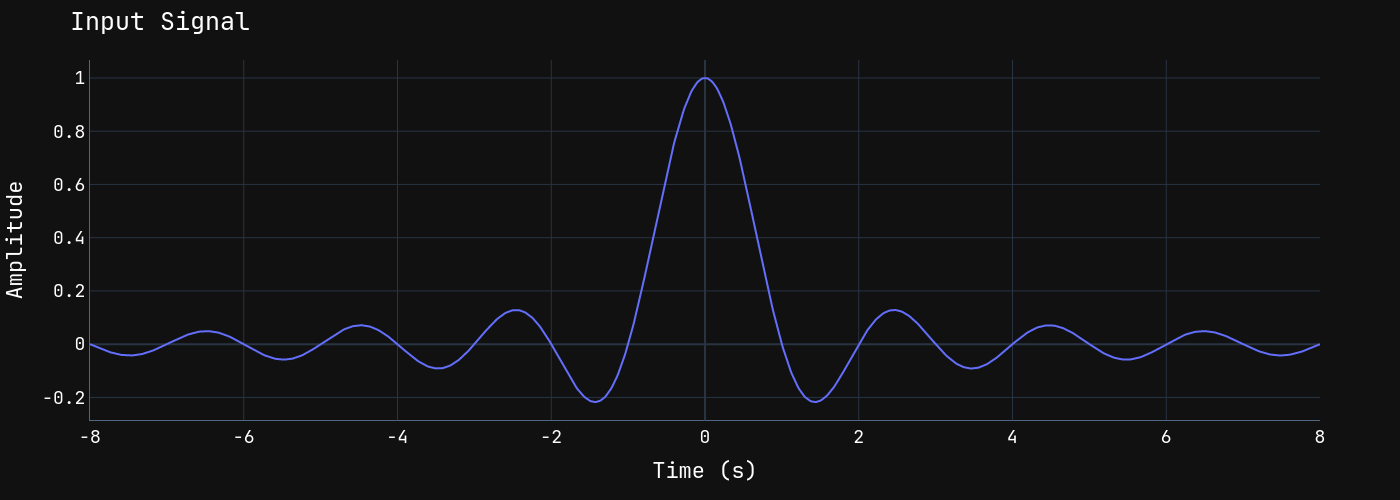

In [163]:
t = np.linspace(-8, 8, 1000)
sinc = np.sinc(t)
fig = px.line(x=t, y=sinc)
fig.update_layout(PLOTLY_LAYOUT)
fig.update_layout(
    title="Input Signal",
    xaxis=dict(title="Time (s)"),
    yaxis=dict(title="Amplitude"),
    width=1400,
    height=500,
)
fig.show("png")

## Compute CFAR criteria

In [164]:
def cfar(x: np.ndarray, compute_cells: int, guard_cells: int, bias: float = 1, method=np.mean):
    pad = int((compute_cells + guard_cells))
    window_mean = np.pad(                                                               # Pad front/back since n_windows < n_points
        method(                                                                         # Take mean of remaining compute cells
            np.delete(                                                                  # Remove guard cells, CUT from computation
                sliding_window_view(x, (compute_cells * 2) + (guard_cells * 2)),        # Windows of x including CUT, guard cells, and compute cells
                np.arange(int(compute_cells), compute_cells + (guard_cells * 2) + 1),   # Get indices of guard cells, CUT
                axis=1), 
            axis=1
        ), (pad - 1, pad),                                                               
        constant_values=(np.nan, np.nan)
    ) * bias                                                                            # Multiply output by bias over which cell is not noise
    return window_mean

## Plot CFAR algo vs. old algo

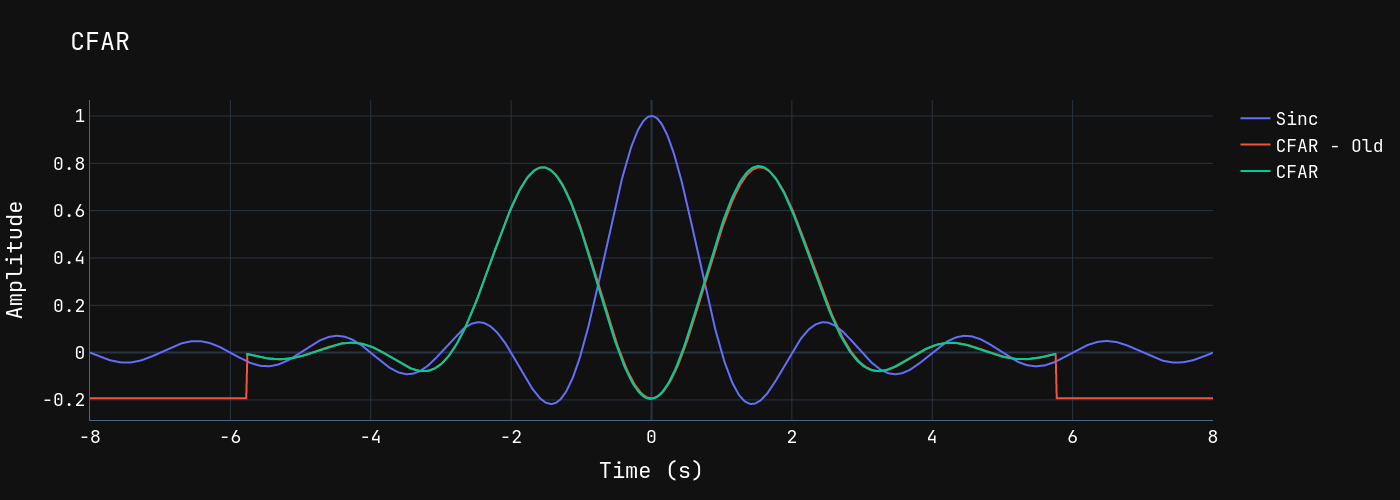

In [194]:
compute_cells = 80
guard_cells = 60
window_mean = cfar(sinc, compute_cells=compute_cells, guard_cells=guard_cells, method=np.mean, bias=2)
output, targets = cfar_old(sinc, num_guard_cells=guard_cells, num_ref_cells=compute_cells, bias=2, cfar_method="average")

fig = make_subplots()
fig.add_trace(go.Scatter(x=t, y=sinc, name="Sinc"))
fig.add_trace(go.Scatter(x=t, y=output, name="CFAR - Old"))
fig.add_trace(go.Scatter(x=t, y=window_mean, name="CFAR"))
fig.update_layout(PLOTLY_LAYOUT)
fig.update_layout(
    title="CFAR",
    xaxis=dict(title="Time (s)"),
    yaxis=dict(title="Amplitude"),
    width=1400,
    height=500,
)
fig.show("png")

## Show compute / guard regions 

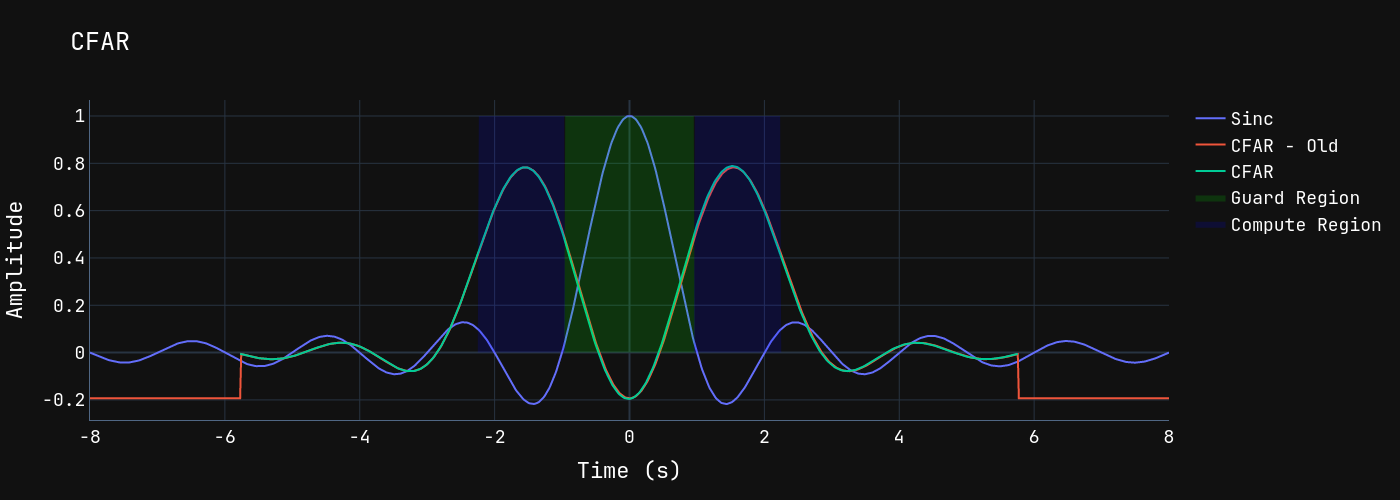

In [193]:
compute_cells = 80
guard_cells = 60
window_mean = cfar(sinc, compute_cells=compute_cells, guard_cells=guard_cells, method=np.mean, bias=2)
output, targets = cfar_old(sinc, num_guard_cells=guard_cells, num_ref_cells=compute_cells, bias=2, cfar_method="average")

def wrap(x, fillval=None):
    if fillval is not None:
        return np.concatenate([x, np.ones(x.size) * fillval])
    return np.concatenate([x, x[::-1]])

def cfar_param_plot(fig, x, guard_cells, compute_cells, ref_index):
    guard_region = np.zeros(x.shape)
    guard_region[np.arange(ref_index - guard_cells, ref_index + guard_cells)] = 1

    compute_region = np.zeros(x.shape)
    compute_region[np.arange(ref_index - guard_cells - compute_cells, ref_index - guard_cells)] = 1
    compute_region[np.arange(ref_index + guard_cells, ref_index + guard_cells + compute_cells)] = 1

    fig.add_trace(go.Scatter(
        x=wrap(t), 
        y=wrap(guard_region, fillval=0), 
        name="Guard Region", 
        fill="toself", 
        fillcolor="rgba(0,255,0,0.15)", 
        line_color="rgba(255,0,0,0)")
    )
    fig.add_trace(go.Scatter(
        x=wrap(t), 
        y=wrap(compute_region, fillval=0), 
        name="Compute Region", 
        fill="toself", 
        fillcolor="rgba(0,0,255,0.15)", 
        line_color="rgba(0,0,0,0)")
    )
    return fig

fig = make_subplots()
fig.add_trace(go.Scatter(x=t, y=sinc, name="Sinc"))
fig.add_trace(go.Scatter(x=t, y=output, name="CFAR - Old"))
fig.add_trace(go.Scatter(x=t, y=window_mean, name="CFAR"))
fig.update_layout(PLOTLY_LAYOUT)
fig.update_layout(
    title="CFAR",
    xaxis=dict(title="Time (s)"),
    yaxis=dict(title="Amplitude"),
    width=1400,
    height=500,
)
cfar_param_plot(fig, t, guard_cells, compute_cells, ref_index=int(t.size / 2))
fig.show("png")

## Get targets
Plot only regions where input signal is above CFAR criteria.

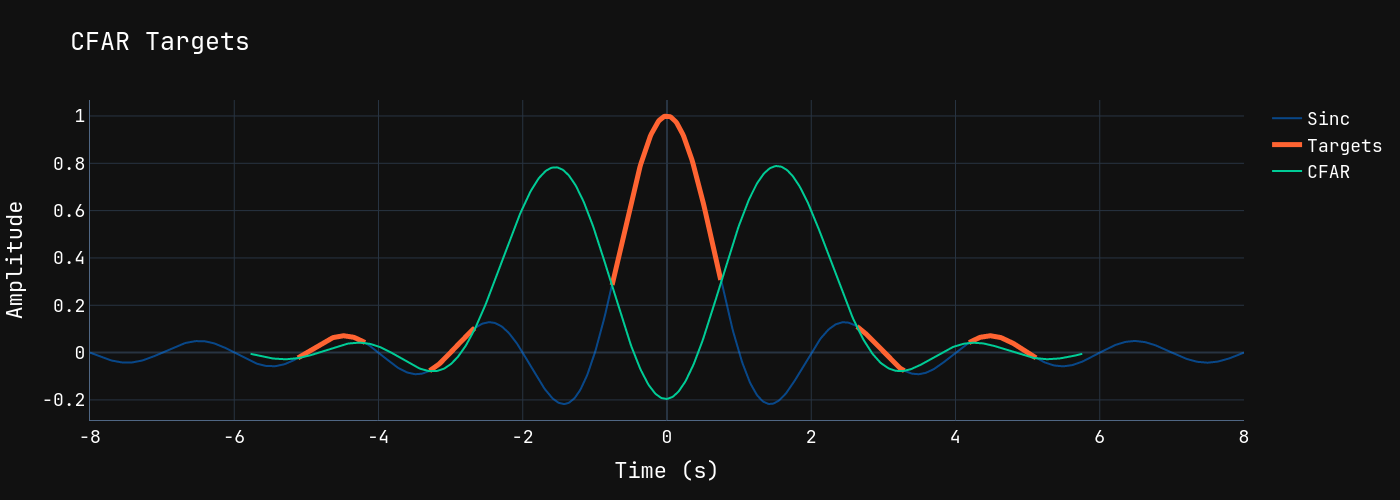

In [322]:
targets = sinc.copy()
targets[np.where((targets < window_mean) | (np.isnan(window_mean)))] = np.nan

fig = make_subplots()
fig.add_trace(go.Scatter(x=t, y=sinc, name="Sinc", line=dict(color="rgba(0,127,255,0.5)")))
fig.add_trace(go.Scatter(x=t, y=targets, name="Targets", line=dict(color="rgba(255,100,50,1)", width=5)))
fig.add_trace(go.Scatter(x=t, y=window_mean, name="CFAR"))
fig.update_layout(PLOTLY_LAYOUT)
fig.update_layout(
    title="CFAR Targets",
    xaxis=dict(title="Time (s)"),
    yaxis=dict(title="Amplitude"),
    width=1400,
    height=500,
)
fig.show("png")

In [266]:
import netCDF4 as nc
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq

In [278]:
ds = nc.Dataset("../app/static/data/Test_Track_2.nc")
iq = ds.variables["i"][:] + 1j * ds.variables["q"][:]

N = iq.shape[1]
fs = 10e6
adc_size = 2**12

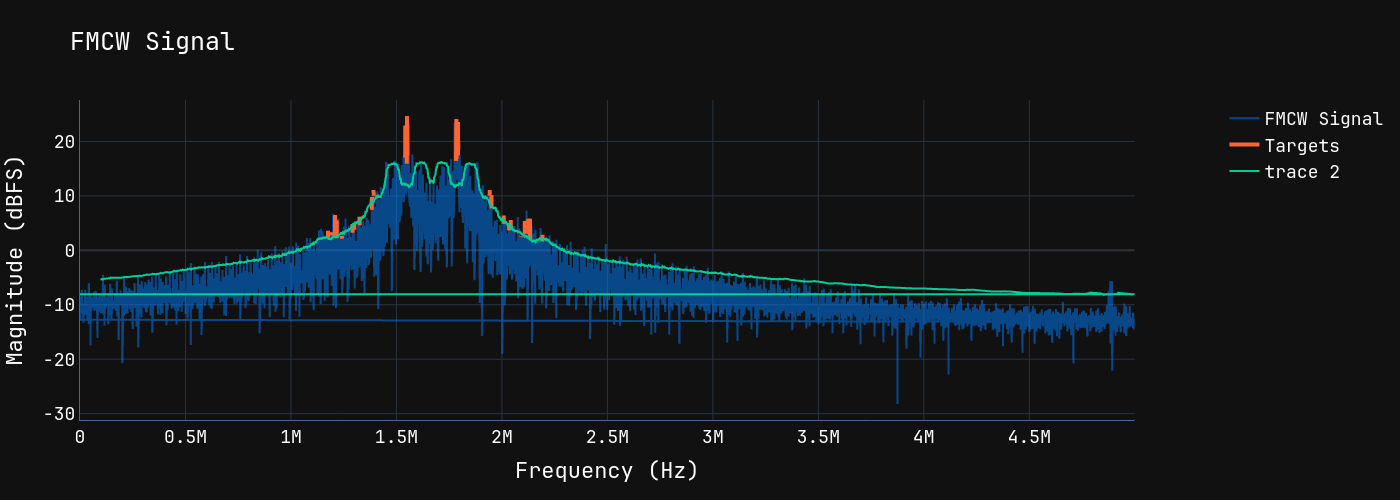

In [323]:
iq_fft = fft(iq[7]) / (2 * N)
freq = fftfreq(N, d=(1 / fs))
threshold = cfar(np.abs(iq_fft), compute_cells=100, guard_cells=60, bias=3)
X_k_dBFS = (10 * np.log10(np.abs(iq_fft)))

targets = X_k_dBFS.copy()
targets[np.where((targets < threshold) | (np.isnan(threshold)))] = np.nan

fig = make_subplots(specs=[[dict(secondary_y=True)]])
fig.add_trace(go.Scatter(x=freq, y=X_k_dBFS, name="FMCW Signal", line=dict(color="rgba(0,127,255,0.5)")))
fig.add_trace(go.Scatter(x=freq, y=targets, name="Targets", line=dict(color="rgba(255,100,50,1)", width=4)))
fig.add_trace(go.Scatter(x=freq, y=10 * np.log10(threshold)), secondary_y=False)
fig.update_layout(PLOTLY_LAYOUT)
fig.update_layout(
    title="FMCW Signal",
    xaxis=dict(title="Frequency (Hz)"),
    yaxis=dict(title="Magnitude (dBFS)"),
    width=1400,
    height=500,
)
fig.update_xaxes(range=[0,freq.max()])
fig.show("png")